In [ ]:
# This file is for param search (optimizing)
'''
Work progress:
1010: Design the structure, using weighted moving average(weighted), merge four csv files 
1011: Check data trend, using weighted moving average, not use on merged four csv file, 
but real separated csv file
'''

'''
How my strategy is designed:

'''

import numpy as np
import pandas as pd
import os, sys, csv

# Implementation part of HW2
def myStrategy(pastData, currPrice, stockType, w, a, b):
    action = 0
    data_len = len(pastData)

    if data_len < w:
        return 0

    windowed_data = pastData[-w:]
    weighted_sum = 0
    weighted_len = 0
    weighted_ma  = 0
    
    for i in range(0, len(windowed_data)):
        weighted_sum += windowed_data[i] * i
        weighted_len += i

    weighted_ma = weighted_sum / weighted_len
    action = 0
    if currPrice - a > weighted_ma:
        action = 1
    elif currPrice + b < weighted_ma:
        action = -1
    else:
        action = 0

    return action

# Compute the return rate of my strategy, this code is from TA
# Compute return rate over a given price vector, with 3 modifiable parameters
def computeReturnRate(priceVec, stockType, windowSize, alpha, beta):
    capital=1000    # Initial available capital
    capitalOrig=capital     # original capital
    dataCount=len(priceVec)                # day size
    suggestedAction=np.zeros((dataCount,1))    # Vec of suggested actions
    stockHolding=np.zeros((dataCount,1))      # Vec of stock holdings
    total=np.zeros((dataCount,1))         # Vec of total asset
    realAction=np.zeros((dataCount,1))    # Real action, which might be different from suggested action. For instance, when the suggested action is 1 (buy) but you don't have any capital, then the real action is 0 (hold, or do nothing). 
    
    # Run through each day
    for ic in range(dataCount):
        currentPrice=priceVec[ic]    # current price
        suggestedAction[ic]=myStrategy(priceVec[0:ic], currentPrice, stockType, windowSize, alpha, beta)        # Obtain the suggested action
        # get real action by suggested action
        if ic>0:
            stockHolding[ic]=stockHolding[ic-1]    # The stock holding from the previous day
        if suggestedAction[ic]==1:    # Suggested action is "buy"
            if stockHolding[ic]==0:        # "buy" only if you don't have stock holding
                stockHolding[ic]=capital/currentPrice # Buy stock using cash
                capital=0    # Cash
                realAction[ic]=1
        elif suggestedAction[ic]==-1:    # Suggested action is "sell"
            if stockHolding[ic]>0:        # "sell" only if you have stock holding
                capital=stockHolding[ic]*currentPrice # Sell stock to have cash
                stockHolding[ic]=0    # Stocking holding
                realAction[ic]=-1
        elif suggestedAction[ic]==0:    # No action
            realAction[ic]=0
        else:
            assert False
        total[ic]=capital+stockHolding[ic]*currentPrice    # Total asset, including stock holding and cash 
    returnRate=(total[-1]-capitalOrig)/capitalOrig        # Return rate of this run
    return returnRate

if __name__=='__main__':
    returnRateBest=-1.00     # Init best return rate
    fileList = ['SPY.csv', 'DSI.csv', 'IAU.csv', 'LQD.csv'] # Init file names
    fileCount=len(fileList)
    
    # Config search range
    windowSizeMin=200; windowSizeMax=500;    # Range of windowSize to explore
    alphaMin=0; alphaMax=30;            # Range of alpha to explore
    betaMin=0; betaMax=20;                # Range of beta to explore
    
    # Start exhaustive search
    for windowSize in range(windowSizeMin, windowSizeMax+1):        # For-loop for windowSize
        for alpha in range(alphaMin, alphaMax+1):            # For-loop for alpha
            for beta in range(betaMin, betaMax+1):        # For-loop for beta
    
                # Evaluate the current confg
                rr=np.zeros((fileCount,1))
                for ic in range(fileCount):
                    file=fileList[ic];
                    df=pd.read_csv(file)    
                    adjClose=df["Adj Close"].values    # Get adj close as the price vector
                    stockType=file[-7:-4]        # Get stock type
                    rr[ic]=computeReturnRate(adjClose, stockType, windowSize, alpha, beta)    # Compute return rate
                    # print("File=%s ==> rr=%f" %(file, rr[ic]));
                
                returnRate = np.mean(rr)
                # print("Current settings: windowSize=%d, alpha=%d, beta=%d ==> avgReturnRate=%f" %(windowSize, alpha, beta ,returnRate))        # Print the best result
                
                returnRate = np.mean(rr)
                if returnRate>returnRateBest:        # Keep the best parameters
                    windowSizeBest=windowSize
                    alphaBest=alpha
                    betaBest=beta
                    returnRateBest=returnRate
                    print("Current best settings: windowSize=%d, alpha=%d, beta=%d ==> avgReturnRate=%f" %(windowSizeBest,alphaBest,betaBest,returnRateBest))        # Print the best result
                    
    print("Overall best settings: windowSize=%d, alpha=%d, beta=%d ==> bestReturnRate=%f" %(windowSizeBest,alphaBest,betaBest,returnRateBest))        # Print the best result

    with open('1011_weighted_ma.txt', 'w') as f:
        f.write()

Current best settings: windowSize=200, alpha=0, beta=0 ==> avgReturnRate=1.005352
Current best settings: windowSize=200, alpha=0, beta=1 ==> avgReturnRate=1.175887
Current best settings: windowSize=200, alpha=0, beta=2 ==> avgReturnRate=1.464786
Current best settings: windowSize=200, alpha=0, beta=3 ==> avgReturnRate=1.543047
Current best settings: windowSize=200, alpha=0, beta=6 ==> avgReturnRate=1.594719
Current best settings: windowSize=200, alpha=0, beta=7 ==> avgReturnRate=1.715803
Current best settings: windowSize=200, alpha=0, beta=8 ==> avgReturnRate=1.727055
Current best settings: windowSize=200, alpha=0, beta=16 ==> avgReturnRate=1.739181
Current best settings: windowSize=200, alpha=0, beta=19 ==> avgReturnRate=1.812654
Current best settings: windowSize=201, alpha=0, beta=19 ==> avgReturnRate=1.814109
Current best settings: windowSize=202, alpha=0, beta=19 ==> avgReturnRate=1.814271


cnt  0


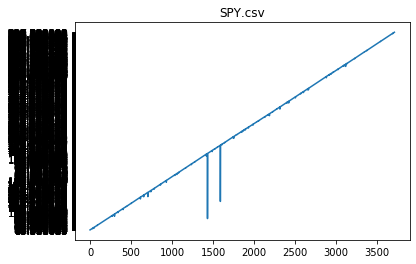

cnt  1


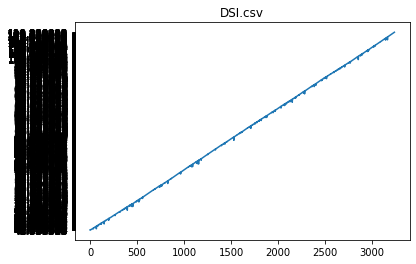

cnt  2


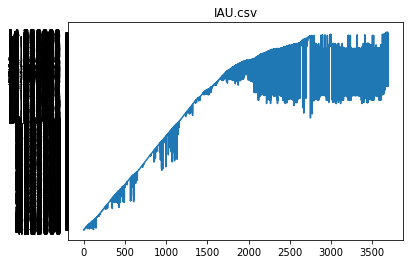

cnt  3


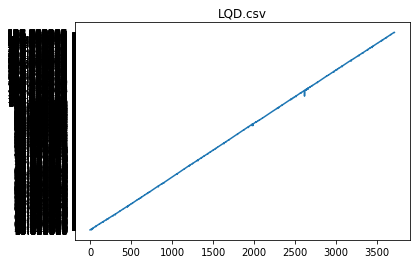

3237


In [3]:
# This file is for graphing and preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, csv

name_todo = ['SPY.csv', 'DSI.csv', 'IAU.csv','LQD.csv']
min_len = 1 << 31
data_mixed = []

COL_ADJ = -2
# check file tendency and make graph
stock_lists = []
# open file
for f_name in name_todo:
    with open(f_name, 'r') as f:
        data = csv.reader(f)
        next(data, None)
        
        cur_len = 0
        stock_list_each = []
        
        for row in data:
            cur_len += 1
            stock_list_each.append(row[COL_ADJ])
            
        min_len = min(min_len, cur_len)
        stock_lists.append(stock_list_each)    
        f.close()

# draw tendency graph
cnt = 0
for stock_list_each in stock_lists:
    plt.clf()
    print('cnt ', cnt)
    plt.title(name_todo[cnt])
    cnt = min(cnt + 1, len(name_todo) - 1)
    plt.plot(stock_list_each)
    plt.show()
 
# merge csv
for i in range(min_len):
    adj_close = 0
    for f_name in name_todo:
        
        with open(f_name, 'r') as f:
            data = csv.reader(f)
            cnt = 0
            next(data, None)
            
            for row in data:
                if cnt == i:
                    adj_close += float(row[COL_ADJ])
                    break
                else:
                    cnt += 1
    
    # print(float(adj_close / len(name_todo)))
    data_mixed.append(float(adj_close / len(name_todo)))

# save merge average data
print(len(data_mixed))
with open('MIX.csv', 'w') as f:
    f.write('Adj Close\n')
    
    for i in data_mixed:
        write_str = str(i) + '\n'
        f.write(write_str)
    
    f.close()